In [ ]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
RS = 7345

# Загрузка данных

In [ ]:
DATA_DIR = pathlib.Path("../data/names/uploads")

In [6]:
train = pd.read_csv("train.csv", index_col="pair_id")
test = pd.read_csv("test.csv", index_col="pair_id")

In [7]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [8]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Contries and cities

In [64]:
cities = pd.read_csv("cities.csv", header=None, encoding='iso-8859-1')
cities.head(10)

,0,1,2,3
0,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",AD
1,Andorra la Vella,Andorra la Vella,"ALV,Ando-la-Vyey,Andora,Andora la Vela,Andora ...",AD
2,Umm Al Quwain City,Umm Al Quwain City,"Oumm al Qaiwain,Oumm al Qaïwaïn,Um al Kawain,U...",AE
3,Ras Al Khaimah City,Ras Al Khaimah City,"Julfa,Khaimah,RAK City,RKT,Ra's al Khaymah,Ra'...",AE
4,Zayed City,Zayed City,"Bid' Zayed,Bid Zayed,Madinat Za'id,Madinat Za...",AE
5,Khawr Fakk?n,Khawr Fakkan,"Fakkan,Fakk?n,Khawr Fakkan,Khawr Fakk?n,Khawr ...",AE
6,Dubai,Dubai,"DXB,Dabei,Dibai,Dibay,Doubayi,Dubae,Dubai,Duba...",AE
7,Dibba Al-Fujairah,Dibba Al-Fujairah,"Al-Fujairah,BYB,Dibba Al-Fujairah,dba alfjyrt,...",AE
8,Dibba Al-Hisn,Dibba Al-Hisn,"BYB,Daba,Daba al-Hisn,Dab?,Dab? al-?i?n,Diba,D...",AE
9,Sharjah,Sharjah,"Al Sharjah,Ash 'Mariqah,Ash Shariqa,Ash Shariq...",AE


# Companies

In [34]:
companies = pd.read_csv("2020-11-19_elf-code-list-v1.3.csv")
companies[['Entity Legal Form name Local name', 'Entity Legal Form name Transliterated name (per ISO 01-140-10)']].head(10)

,Entity Legal Form name Local name,Entity Legal Form name Transliterated name (per ISO 01-140-10)
0,NaN,NaN
1,NaN,NaN
2,International Business Corporation,International Business Corporation
3,Sociedad Anonima,Sociedad Anonima
4,Sociedad Cooperativa,Sociedad Cooperativa
5,Sociedad Anonima Unipersonal,Sociedad Anonima Unipersonal
6,Stichting,Stichting
7,Vennootschap onder firma,Vennootschap onder firma
8,Commanditaire vennootschap (1),Commanditaire vennootschap (1)
9,Besloten vennootschap,Besloten vennootschap


In [56]:
companies = companies[['Entity Legal Form name Local name', 'Entity Legal Form name Transliterated name (per ISO 01-140-10)']]

duplicate_companies = []
for i, (name_1, name_2) in companies.iterrows():
    if isinstance(name_1, str) and isinstance(name_2, str):
        if name_1 != name_2:
            duplicate_companies.append((name_1, name_2))
    

In [58]:
duplicate_companies[:10]

[('Закрытае акцыянернае таварыства', 'Zakrytae akcyyanernae tavarystva'),
 ('Закрытое акционерное общество', 'Zakrytoe akcionernoe obshchestvo'),
 ('Унітарнае прадпрыемства', 'Unіtarnae pradpryemstva'),
 ('Унитарное предприятие', 'Unitarnoe predpriyatie'),
 ('Таварыства з абмежаванай адказнасцю',
  'Tavarystva z abmezhavanaj adkaznascyu'),
 ('Общество с ограниченной ответственностью',
  "Obshchestvo s ogranichennoj otvetstvennost'yu"),
 ('Таварыства з дадатковай адказнасцю', 'Tavarystva z dadatkovaj adkaznascyu'),
 ('Общество с дополнительной ответственностью',
  "Obshchestvo s dopolnitel'noj otvetstvennost'yu"),
 ('Адкрытае акцыянернае таварыства', 'Adkrytae akcyyanernae tavarystva'),
 ('Открытое акционерное общество', 'Otkrytoe akcionernoe obshchestvo')]

# Статистика таргета

In [10]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [11]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
395382,Ikea Distribution Services Gmb H,Ikea Distribution Service(Shanghai),1
209566,Bridgestone Tire,Bridgestone (China) Research And Development C...,1
263594,Dow Chemical Thailand Ltd.,Dow Chemical Pacific,1
458214,Freudenberg Nok De Mexico Sa De Cv,Freudenberg Nok Componentes Brasil Ltda,1
388667,Arlanxeo Brasil Sa,Arlanxeo Singapore Pte.,1
158075,Basf Pakistan (Private) Ltd.,"Basf Co., Ltd.",1
163396,Soprema Canada,SOPREMA OBERROSSBACH,1
390723,"Sumitomo Rubber (Changshu) Co., Ltd.",Sumitomo Rubber Do Brasil Ltda,1
56580,Yokohama Tire Canada,Yokohama Re Mfg.,1


In [12]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
130514,R.H. Claydon Ltd.(Saxham),R.I.Intl,0
213799,Solid Cement,Lg Chem Ltd.,0
237941,Zara Brasil Ltd. Av Ribeirao Dos Cri,V.D.,0
62414,"Carlton Overseas Pvt., Ltd.",Infusion Overseas Private Ltd.,0
275797,Sportworx 2012 Ltd.,Elisei Nastri Trasportatori,0
138235,"Genius Industrial Supply Co., Ltd.",D S International,0
154412,Great Worldwide Logistics,Ez Logistics Llc,0
284958,Hps North America Inc.,Icl America Ltd.,0
150053,Gates India P. Ltd.,Indo Rama Synthetics (India) Ltd.,0


# Очистка данных

In [13]:
!pip install pycountry

     |████████████████████████████████| 10.1MB 3.9MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=06bd1e8af7071613df1a84124780d49b7b967a784672da20abe4a9500201af11
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [14]:
import pycountry
import re

In [15]:
!pip install countryinfo

     |████████████████████████████████| 604kB 5.6MB/s 


In [24]:
!pip install textdistance

In [ ]:
import countryinfo
help(countryinfo.CountryInfo)

In [ ]:
countries = [country.name.lower() for country in pycountry.countries]

In [ ]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [ ]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate
pair_id,,,
40,isoliererzeugnisse grobrohrsdorf gmbh,total rumunia,0
410,dortmunder gussasphalt gmbh & co. kg,bitoumina s.a.,0
440,celanese chemicals europe gmbh,inreco - emulsja sp. z o.o.,0
583,tremco illbruck group gmbh,wakol gmbh,0
681,rasco bitumentechnik gmbh,technpvinyl polymers india ltd.,0
...,...,...,...
497197,binne & sohn gmbh & co kg,buscher hoffmann,0
497306,mct gmbh & co. kg,valli zabban,0
497366,mct misch & compoundier technik gmbh,nknh,0


In [ ]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]

for entity in tqdm(legal_entities):
    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

100%|██████████| 7/7 [00:14<00:00,  2.08s/it]


In [ ]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries,"enormous industrial trade,",0
2,apcotex industries,technocraft industries (india),0
3,"rishichem distributors,",dsa,0
4,powermax rubber factory,co. one,0
5,tress a/s,longyou industries park zhejiang,0


In [ ]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan sa cv
2,eih,"dongguan wei shi plastic product,"
3,jsh(hk),arab shipbuilding and repair yard c
4,better industrial,farmacap industria eercio
5,equipos inoxidables del norte sa de cv,bel


In [ ]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [ ]:
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [06:29<00:00,  1.56s/it]


In [ ]:
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [ ]:
train.sample(25)

,name_1,name_2,is_duplicate
pair_id,,,
244919,bommer industries,blackwater industry international sac,0
353290,techmer de s de rl de cv,riintl,0
488793,yili engineering plastics technology,deengineering,0
101085,samsung electronics home appliance,samson international,0
446269,cmax enterprises,sr enterprises,0
142987,zam zam enterprises,yk enterprise,0
78746,david jones private label,hge international private,0
108862,dass nordeste calcados e artigos esportivos sa,seafrigo,0
254219,mcl,shri krishan rubber chemical,0


In [ ]:
test.sample(25)

,name_1,name_2
pair_id,,
61881,guang zhou lead fair plastic,berry plasticsporation
180095,123 e latin america s de rl de cv,apparel merchandising
77672,xiamen gulong imp expco,dongguan global imp exp
10059,farmacap industria eercio,balkrishna industria
101813,jiangsu zhongxiang chemical trading,kia
161964,nrc industries,makino auto industries
190318,gp,sperry plast
207668,adk international,south service trading sa
71813,ounporation,irrigation products international


# Простые метрики сходства строк

In [ ]:
!pip install strsimpy

     |████████████████████████████████| 51kB 2.9MB/s 


In [ ]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

In [ ]:
levenshtein = Levenshtein()

train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 213249/213249 [00:36<00:00, 5851.94it/s]


In [ ]:
train.head()

In [ ]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

100%|██████████| 213249/213249 [00:37<00:00, 5691.00it/s]


In [ ]:
train.head()

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
1,iko industries,enormous industrial trade,0,15.0,0.600000
2,apcotex industries,technocraft industries,0,9.0,0.409091
3,rishichem distributors,dsa,0,20.0,0.909091
4,powermax rubber factory,co one,0,20.0,0.869565
5,tress as,longyou industries park zhejiang,0,26.0,0.812500


In [ ]:
test.head()

,name_1,name_2,levenstein,norm_levenstein
pair_id,,,,
1,sun blinds decoration,indl de cuautitlan sa cv,20.0,0.833333
2,eih,dongguan wei shi plastic product,29.0,0.906250
3,jshhk,arab shipbuilding and repair yard c,33.0,0.942857
4,better industrial,farmacap industria eercio,15.0,0.600000
5,equipos inoxidables del norte sa de cv,bel,35.0,0.921053


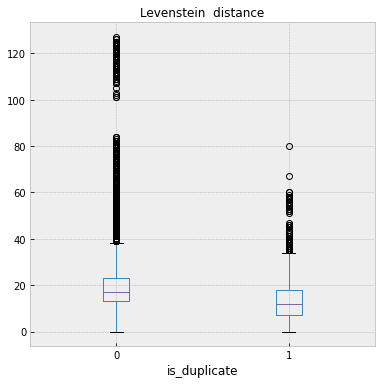

In [ ]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

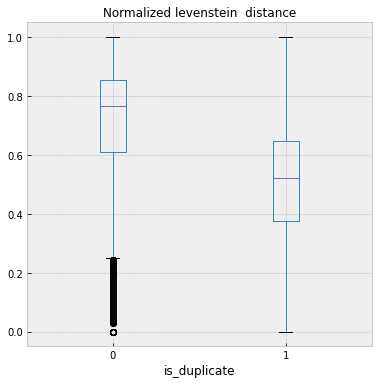

In [ ]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

# Мои расстояния

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
train["partial_ratio"] = train.progress_apply(lambda r: fuzz.partial_ratio(r.name_1, r.name_2) / 100, axis=1)
test["partial_ratio"] = test.progress_apply(lambda r: fuzz.partial_ratio(r.name_1, r.name_2) / 100, axis=1)

train["token_sort_ratio"] = train.progress_apply(lambda r: fuzz.token_sort_ratio(r.name_1, r.name_2) / 100, axis=1)
test["token_sort_ratio"] = test.progress_apply(lambda r: fuzz.token_sort_ratio(r.name_1, r.name_2)  / 100, axis=1)

train["token_set_ratio"] = train.progress_apply(lambda r: fuzz.token_set_ratio(r.name_1, r.name_2) / 100, axis=1)
test["token_set_ratio"] = test.progress_apply(lambda r: fuzz.token_set_ratio(r.name_1, r.name_2) / 100, axis=1)

train["WRatio"] = train.progress_apply(lambda r: fuzz.WRatio(r.name_1, r.name_2) / 100, axis=1)
test["WRatio"] = test.progress_apply(lambda r: fuzz.WRatio(r.name_1, r.name_2) / 100, axis=1)

100%|██████████| 213249/213249 [02:05<00:00, 1704.92it/s]


In [ ]:
train["partial_ratio"] = train.progress_apply(lambda r: fuzz.partial_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["partial_ratio"] = test.progress_apply(lambda r: fuzz.partial_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)

train["token_sort_ratio"] = train.progress_apply(lambda r: fuzz.token_sort_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["token_sort_ratio"] = test.progress_apply(lambda r: fuzz.token_sort_ratio(r.stopw_name_1, r.stopw_name_2)  / 100, axis=1)

train["token_set_ratio"] = train.progress_apply(lambda r: fuzz.token_set_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["token_set_ratio"] = test.progress_apply(lambda r: fuzz.token_set_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)

train["WRatio"] = train.progress_apply(lambda r: fuzz.WRatio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["WRatio"] = test.progress_apply(lambda r: fuzz.WRatio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)

 13%|█▎        | 28496/213249 [01:00<06:26, 478.62it/s]

# Lemmatizer

In [ ]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
lemmatizer = WordNetLemmatizer() #  lemmatizer.lemmatize(word)
stemmer = PorterStemmer() # stemmer.stem(word)

In [ ]:
words = nltk.word_tokenize(train['name_1'].iloc[1])
for word in words:
    res = lemmatizer.lemmatize(word)
    print(res)

apcotex
industry


In [ ]:
words = nltk.word_tokenize(train['name_2'].iloc[1])
res = [lemmatizer.lemmatize(word) for word in words]
print(' '.join([lemmatizer.lemmatize(word) for word in words]))

technocraft industry


In [ ]:
train.head()

,name_1,name_2,is_duplicate,levenstein,norm_levenstein,partial_ratio,token_sort_ratio,token_set_ratio,WRatio
pair_id,,,,,,,,,
1,iko industries,enormous industrial trade,0,15.0,0.600000,71,56,56,64
2,apcotex industries,technocraft industries,0,9.0,0.409091,72,50,71,67
3,rishichem distributors,dsa,0,20.0,0.909091,67,16,16,60
4,powermax rubber factory,co one,0,20.0,0.869565,36,34,34,43
5,tress as,longyou industries park zhejiang,0,26.0,0.812500,75,20,20,68


In [ ]:
from nltk.corpus import stopwords

en = stopwords.words("english")
rus = stopwords.words("russian")
stop_words = en.extend(rus)

words = nltk.word_tokenize(sentence)
without_stop_words = [word for word in words if not word in stop_words]


In [ ]:
train['lemm_name_1'] = train['name_1'].apply(lambda sentance: ' '.join([lemmatizer.lemmatize(w) for w in sentance])) 
test['lemm_name_1']  = test['name_1'].apply(lambda sentance: ' '.join([lemmatizer.lemmatize(w) for w in sentance])) 

train['lemm_name_2'] = train['name_2'].apply(lambda sentance: ' '.join([lemmatizer.lemmatize(w) for w in sentance])) 
test['lemm_name_2']  = test['name_2'].apply(lambda sentance: ' '.join([lemmatizer.lemmatize(w) for w in sentance])) 

In [ ]:
from nltk.corpus import stopwords

en = stopwords.words("english")
rus = stopwords.words("russian")
stop_words = en + rus

train['stopw_name_1'] = train['lemm_name_1'].apply(lambda sentance: ' '.join([w for w in sentance if not w in stop_words])) 
test['stopw_name_1']  = test['lemm_name_1'].apply(lambda sentance: ' '.join([w for w in sentance if not w in stop_words])) 

train['stopw_name_2'] = train['lemm_name_2'].apply(lambda sentance: ' '.join([w for w in sentance if not w in stop_words])) 
test['stopw_name_2']  = test['lemm_name_2'].apply(lambda sentance: ' '.join([w for w in sentance if not w in stop_words])) 

# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
values = tfidf_vectorizer.fit_transform(documents)

# Show the Model as a pandas DataFrame
feature_names = tfidf_vectorizer.get_feature_names()
pd.DataFrame(values.toarray(), columns = feature_names)

# Мои модели

C norm_levenstein - максимально 0.27 на пороге 0.85
Без него 0.38 на пороге 0.9

In [ ]:
FTS = ["partial_ratio", "token_sort_ratio", "token_set_ratio", "WRatio"]
THR = 0.9

In [ ]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=RS)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [ ]:
model = LogisticRegression(class_weight="balanced")
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

for thr in np.arange(0.5, 1, 0.05):
    tr_pred = (tr_preds[:, 1] > thr).astype(np.int)
    cv_pred = (cv_preds[:, 1] > thr).astype(np.int)

    print("thr =", thr, f1_score(train.iloc[tridx]["is_duplicate"].values, tr_pred))
    print("thr =", thr, f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_pred))

thr = 0.5 0.04444945848375451
thr = 0.5 0.0450729450393642
thr = 0.55 0.04764859429158287
thr = 0.55 0.04782737968823005
thr = 0.6000000000000001 0.051907449910055206
thr = 0.6000000000000001 0.05205264191710862
thr = 0.6500000000000001 0.06104809050138887
thr = 0.6500000000000001 0.06102737619194094
thr = 0.7000000000000002 0.07705787006614974
thr = 0.7000000000000002 0.07738919667590027
thr = 0.7500000000000002 0.10032351883925361
thr = 0.7500000000000002 0.10167310167310166
thr = 0.8000000000000003 0.17763257863546572
thr = 0.8000000000000003 0.18252776943860705
thr = 0.8500000000000003 0.3360323886639676
thr = 0.8500000000000003 0.3521505376344086
thr = 0.9000000000000004 0.37960220059246724
thr = 0.9000000000000004 0.3882845188284519
thr = 0.9500000000000004 0.0
thr = 0.9500000000000004 0.0


In [ ]:
thr = 0.9
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

tr_preds = (tr_preds[:, 1] > thr).astype(np.int)
cv_preds = (cv_preds[:, 1] > thr).astype(np.int)

print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.37960220059246724
0.3882845188284519


Best threshold = 0.85

# Базовая модель

In [ ]:
FTS = ["levenstein", "norm_levenstein"]
THR = 0.9

In [ ]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=RS)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [ ]:
model = LogisticRegression(class_weight="balanced")
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [ ]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [ ]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    395329
           1       0.17      0.13      0.15      2926

    accuracy                           0.99    398255
   macro avg       0.58      0.56      0.57    398255
weighted avg       0.99      0.99      0.99    398255



In [ ]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     98832
           1       0.17      0.14      0.15       732

    accuracy                           0.99     99564
   macro avg       0.58      0.57      0.57     99564
weighted avg       0.99      0.99      0.99     99564



In [ ]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.14792338327327895
0.15128593040847202


# Генерация сабмита

In [ ]:
sample_sub = pd.read_csv("sample_submission.csv", index_col="pair_id")

In [ ]:
sample_sub

,is_duplicate
pair_id,
1,1
2,1
3,1
4,1
5,1
...,...
213245,1
213246,1
213247,1


In [ ]:
THR = 0.85

In [ ]:
sample_sub["is_duplicate"] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)

In [ ]:
sample_sub.is_duplicate.value_counts()

0    210909
1      2340
Name: is_duplicate, dtype: int64

In [ ]:
sample_sub.to_csv("my_submission.csv")